
### Load the data
Load the preprocessed datasets for each run


In [1]:
# Let's keep our notebook clean, so it's a little more readable!
import warnings
warnings.filterwarnings('ignore')


In [2]:
import os

# Set variables
#ROOT_DATA='/Users/home/Documents/BIDS/'
ROOT_DATA=r"C:\Users\bdireito\Desktop\Data\DATA_ananogueira\func"

SUB=['sub-0001', 'sub-0002']

SES='ses-001'

TASK=['nomeacaoinner', 'nomeacaoovert']
TASK='nomeacaoinner'

RUN='run-01'

# project folder
ROOT_PROJECT=r'C:\Users\bdireito\Documents\GitHub\MVPA-speech_project\anan0gueira-Git'


### Combine datasets

Here, we are going com combine the different runs (whole-brain beta series, X) from a specific participant and the target condition for each event (y).


In [15]:
import nilearn
from nilearn import image
from nilearn.image import mean_img,math_img,index_img,concat_imgs

import numpy as np

import pandas as pd

#### Combine volumes from both datasets.

In [16]:

bs_maps=None

# Iterate runs.
for s in SUB:
    
    # Load data for each RUN r.
    bs_fn=os.path.join(s + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')
    bs_map= image.load_img(bs_fn)
 
    if bs_maps is None:
        bs_maps=bs_map
  
    else:
        bs_maps=[bs_maps,bs_map]

    
    del bs_map
    
bs_maps=concat_imgs(bs_maps, auto_resample=True)
print(bs_maps.shape)


(91, 109, 91, 248)


#### Combine classification target files

In [17]:

classification_target=None
labels=None

# Iterate runs.
for s in SUB:
    
    
    # Load labels for each RUN r.
    labels_fn=os.path.join(s + '_' + SES + '_task-' + TASK + '_'+ RUN +'_labels.csv')
    col_list = ["0"]
    labels=pd.read_csv(labels_fn, usecols=col_list)
    
    # classification baseline vs. naming task.
    labels.loc[labels['0'] != 0, ['0']] = 1
       
    if classification_target is None:
        classification_target=labels
    else:
        classification_target=pd.concat((classification_target, labels))
    
    #del labels
    
classification_target=classification_target.rename(columns={'0':'condition'})
classification_target.head(10)
    
    

,condition
0,0
1,0
2,0
3,0
4,0
5,1
6,1
7,1
8,1
9,1


<AxesSubplot:xlabel='condition', ylabel='count'>

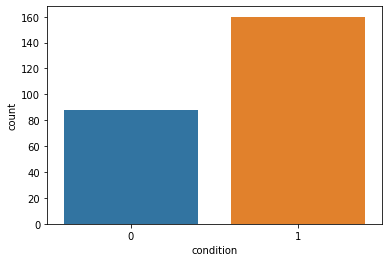

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(classification_target['condition'])

### Mask selection - features
Here we select the different masks (i.e. brain regions) used to classify.
To this end, we will use a predined atlas with anatomical predefined regions.

Please note that:
- CHECK FERREIRA et al., to define brain regions

In [19]:
from nilearn import datasets

# Load atalas.
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
atlas_filename = dataset.maps


In [20]:
#dataset
#print(dataset.labels[12])

In [21]:
# Define the masks to be used in the for loop.
areas=[[47,48,46,5],[47,48],[46,5], [46], [5], [12]]

areas=[[47,48,46,5]]

### Prepare data for machine learning

Here, we will define a “training sample” where we can play around with our models (cross-validation). 

We will also set aside a “test” sample that we will not touch until the end ()

We want to be sure that our training and test sample are matched! We can do that with a “stratified split”. Specifically, we will stratify by age class.

In [22]:
numclasses=len(np.unique(classification_target))

In [23]:
# Define target array of strings.

targets=[]
for i in range(numclasses): 
    targets.append(str(i)) 
    
print(targets)

['0', '1']


In [24]:
# Cross-validation
cv = 3

classifiers_data = {}

# use different targets 2 class (baseline vs all others) e 5-class

# use different kernels
kernel='rbf' #'rbf' 'linear' 'poly'

# use different masks

______________________________________________________________________
number of features: 7592 training: 198 testing: 50
Accuracy with cross validation: 73.737
Accuracy without cross validation: 96.465


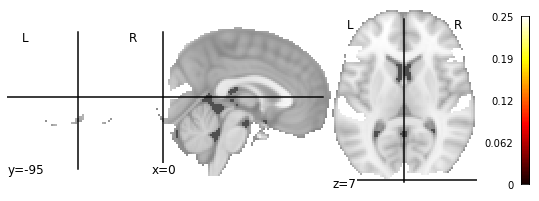

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from nilearn import plotting

from nilearn.input_data import NiftiMasker
from sklearn.model_selection import cross_val_score, cross_val_predict
import time


for idx, area in enumerate(areas): 
    
    classifiers_data[idx] = {}
    
    print(70 * '_')
    
    # -------------------- MASKER
    
    # Create img based on atlas mask.
    mask = mean_img([math_img('img == %d'  %i, img=atlas_filename) for i in area])
    
    # Plot mask.
    plotting.plot_stat_map(mask)
    plotting.show
    
    # Create masker object to extrach data from beta series.
    masker=NiftiMasker(mask_img=mask, standardize=True)
    X_features=masker.fit_transform(bs_maps)
    
    
    # -------------------- TRAIN TEST split

    # Split the sample to training/test with a 70/30 ratio, and
    # stratify by age class, and also shuffle the data.

    X_train, X_test, y_train, y_test = train_test_split(
                                                        X_features, # x
                                                        classification_target['condition'], # y
                                                        test_size = 0.2, # 80%/20% split  
                                                        shuffle = True, # shuffle dataset
                                                                        # before splitting
                                                        stratify = classification_target['condition'], # keep
                                                                               # distribution
                                                                               # of condtions
                                                                               # consistent
                                                                               # betw. train
                                                                               # & test sets.
                                                        random_state = 123 # same shuffle each
                                                                           # time
                                                                           )

    ## print the size of our training and test groups
    print('number of features:', X_features.shape[1], 'training:', len(X_train), 'testing:', len(X_test))
    
    # -------------------- Create new classifier model.
    decoder = SVC(kernel=kernel)
    
    # ---- TRAIN model ----

    
    # Initiate timer to determine how long it takes.
    t0 = time.time()
    

    # Save the area/label/mask used in this iteration.
    classifiers_data[idx]['areas'] = area

    # Save the number of voxels of this mask.
    classifiers_data[idx]['number_voxels'] = X_features.shape[1]
    
    # Save kernel of the SVM classifier.
    classifiers_data[idx]['kernel']=kernel
    
    # Save the Cross-validation results - cv=cv.
    classifiers_data[idx]['train_score_cv'] = cross_val_score(decoder, X_train, y_train, cv=cv, scoring='accuracy')
    y_pred_train_cv = cross_val_predict(decoder, X_train, y_train,groups=y_train, cv=cv)
    acc_train_cv = (y_pred_train_cv == y_train).mean() * 100.
    
    print("Accuracy with cross validation: %.3f" % acc_train_cv)
    
    # --- Train model with the training set.
    decoder.fit(X_train, y_train)
    
    # Save the non-cross validation data
    classifiers_data[idx]['train_score'] = decoder.score(X_train, y_train)
    
    # Compare with prediction.
    y_pred_train = decoder.predict(X_train)
    acc_train = (y_pred_train == y_train).mean() * 100.
    
    print("Accuracy without cross validation: %.3f" % acc_train)
    
    # print("%10s: %.2fs" % (idx, time.time() - t0))
    
    
    # ---- TEST model ----
    
    #classifiers_data[idx]['test_score'] = decoder.score(X_test, y_test)
    #print(classifiers_data[idx])
    
    

### Let's analyze the training results 
With cross-validation.

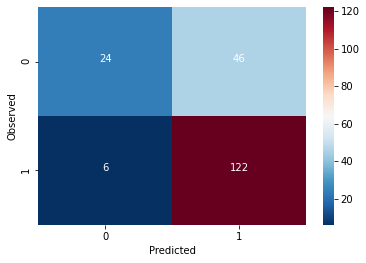

In [27]:
import itertools
from pandas import DataFrame

from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score

# calculate the model precision, recall and f1, all in one convenient report!
cr = classification_report(y_true=y_train,
                      y_pred=y_pred_train_cv)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred_train_cv)

# plot confusion matrix
cmdf = DataFrame(cm, index = targets, columns = targets)
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

Without cross-validation.

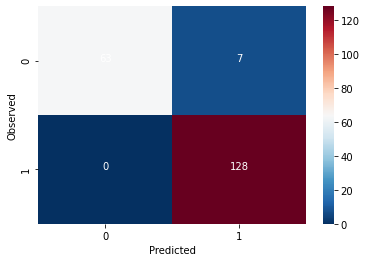

In [28]:


# calculate the model precision, recall and f1, all in one convenient report!
cr = classification_report(y_true=y_train,
                      y_pred=y_pred_train)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred_train)

# plot confusion matrix
cmdf = DataFrame(cm, index = targets, columns = targets)
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

### Testing the model

In [29]:
y_pred_test = decoder.predict(X_test)
classifiers_data[idx]['test_score'] = decoder.score(X_test, y_test)

print(classifiers_data[idx])

{'areas': [47, 48, 46, 5], 'number_voxels': 7592, 'kernel': 'rbf', 'train_score_cv': array([0.74242424, 0.71212121, 0.75757576]), 'train_score': 0.9646464646464646, 'test_score': 0.9}


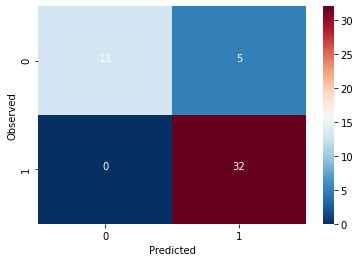

In [30]:
# calculate the model precision, recall and f1, all in one convenient report!
cr = classification_report(y_true=y_test,
                      y_pred=y_pred_test)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_test, y_pred = y_pred_test)

# plot confusion matrix
cmdf = DataFrame(cm, index = targets, columns = targets)
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")


In [31]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       0.86      1.00      0.93        32

    accuracy                           0.90        50
   macro avg       0.93      0.86      0.88        50
weighted avg       0.91      0.90      0.90        50

